# Step 4 · Cleaning pipeline validation

Validate the precipitation cleaning logic inside the notebook without relying on the service package.

## 0. Setup
Run this notebook from the repo root so relative paths work.

In [ ]:
from __future__ import annotations

import json
from dataclasses import dataclass
from datetime import datetime, timezone, timedelta
from pathlib import Path
from typing import Optional
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
import sqlalchemy as sa
from dotenv import load_dotenv


### Globals & Helper Types

In [ ]:
OUTLIER_FLAG = 1
IMPUTED_FLAG = 2
POOR_QUALITY_FLAG = 4

@dataclass(slots=True)
class CleanerConfig:
    min_value_mm: float = 0.0
    max_value_mm: float = 150.0
    min_quality: Optional[float] = None
    interpolation_limit: int = 6



### Cleaning Logic

In [ ]:
def clean_measurements(raw_df: pd.DataFrame, cfg: CleanerConfig) -> pd.DataFrame:
    if raw_df.empty:
        return pd.DataFrame(columns=["sensor_id", "ts", "value_mm", "qc_flags", "imputation_method", "version"])

    results = []
    for sensor_id, group in raw_df.groupby("sensor_id"):
        cleaned = _clean_sensor_dataframe(sensor_id, group, cfg)
        if not cleaned.empty:
            results.append(cleaned)
    if not results:
        return pd.DataFrame(columns=["sensor_id", "ts", "value_mm", "qc_flags", "imputation_method", "version"])
    return pd.concat(results, ignore_index=True)


def _clean_sensor_dataframe(sensor_id: str, df: pd.DataFrame, cfg: CleanerConfig) -> pd.DataFrame:
    df = df.sort_values("ts").reset_index(drop=True)
    ts_index = pd.to_datetime(df["ts"], utc=True)

    values = pd.to_numeric(df["value_mm"], errors="coerce")
    clean_series = pd.Series(values.to_numpy(dtype=float), index=ts_index, dtype=float)

    qc_flags = np.zeros(len(df), dtype=np.int32)

    outlier_mask = (clean_series < cfg.min_value_mm) | (clean_series > cfg.max_value_mm)
    clean_series[outlier_mask] = np.nan
    qc_flags[outlier_mask.to_numpy()] |= OUTLIER_FLAG

    if cfg.min_quality is not None and "quality" in df:
        quality = pd.to_numeric(df["quality"], errors="coerce")
        poor_quality_mask = quality < cfg.min_quality
        poor_quality_mask = poor_quality_mask.fillna(False)
        if poor_quality_mask.any():
            clean_series[poor_quality_mask.to_numpy()] = np.nan
            qc_flags[poor_quality_mask.to_numpy()] |= POOR_QUALITY_FLAG

    imputation_method = pd.Series(index=clean_series.index, dtype="object")
    missing_before = clean_series.isna()

    if missing_before.any():
        gbm_filled, labels = gbm_forecast_fill(clean_series, cfg)
        clean_series = clean_series.copy()
        clean_series.loc[missing_before] = gbm_filled.loc[missing_before]
        imputation_method.loc[labels.notna()] = labels.loc[labels.notna()]
    
    remaining = clean_series.isna()
    if remaining.any():
        interp = clean_series.interpolate(method="time", limit_direction="both")
        clean_series.loc[remaining & interp.notna()] = interp.loc[remaining & interp.notna()]
        imputation_method.loc[remaining & interp.notna()] = "time_interp"

    clean_series = clean_series.clip(lower=cfg.min_value_mm, upper=cfg.max_value_mm)

    imputed_mask = imputation_method.notna()
    qc_flags[imputed_mask.to_numpy()] |= IMPUTED_FLAG

    valid_mask = ~clean_series.isna()
    if not valid_mask.any():
        return pd.DataFrame(columns=["sensor_id", "ts", "value_mm", "qc_flags", "imputation_method", "version"])

    qc_flags_series = pd.Series(qc_flags, index=clean_series.index)
    imputation_method = imputation_method.where(imputation_method.notna(), None)

    result = pd.DataFrame(
        {
            "sensor_id": sensor_id,
            "ts": clean_series.index,
            "value_mm": clean_series.values,
            "qc_flags": qc_flags_series.values,
            "imputation_method": imputation_method.values,
            "version": 1,
        }
    )

    result = result[valid_mask.values].reset_index(drop=True)
    return result


def gbm_forecast_fill(series: pd.Series, cfg: CleanerConfig, random_state: int = 42) -> tuple[pd.Series, pd.Series]:
    series = series.copy().astype(float)
    labels = pd.Series(index=series.index, dtype="object")

    df = pd.DataFrame({
        "y": series,
        "lag1": series.shift(1),
        "lag2": series.shift(2),
        "lag3": series.shift(3),
        "hour": series.index.hour,
        "dow": series.index.dayofweek,
        "month": series.index.month,
    })

    feature_cols = ["lag1", "lag2", "lag3", "hour", "dow", "month"]
    train_df = df.dropna(subset=["y"] + feature_cols)

    if len(train_df) < 30:
        # fallback to interpolation if not enough history
        interp = series.interpolate(method="time", limit_direction="both")
        interp = interp.clip(lower=cfg.min_value_mm, upper=cfg.max_value_mm)
        labels.loc[series.isna() & interp.notna()] = "time_interp"
        return interp, labels

    model = HistGradientBoostingRegressor(max_depth=3, learning_rate=0.1, random_state=random_state)
    model.fit(train_df[feature_cols], train_df["y"])

    filled = series.copy()
    missing_positions = [pos for pos, value in enumerate(filled.values) if np.isnan(value)]

    for pos in missing_positions:
        ts = filled.index[pos]
        lags = [
            filled.iloc[pos - 1] if pos - 1 >= 0 else np.nan,
            filled.iloc[pos - 2] if pos - 2 >= 0 else np.nan,
            filled.iloc[pos - 3] if pos - 3 >= 0 else np.nan,
        ]
        if any(pd.isna(val) for val in lags):
            continue
        features = [[lags[0], lags[1], lags[2], ts.hour, ts.dayofweek, ts.month]]
        pred = float(model.predict(features)[0])
        pred = float(np.clip(pred, cfg.min_value_mm, cfg.max_value_mm))
        filled.iloc[pos] = pred
        labels.iloc[pos] = "gbm_forecast"

    remaining = filled.isna()
    if remaining.any():
        fallback = train_df["y"].median()
        if pd.isna(fallback):
            fallback = cfg.min_value_mm
        filled.loc[remaining] = fallback
        labels.loc[remaining] = "global_median"

    return filled, labels


### DB Utilities (Optional)

In [ ]:
from sqlalchemy import text

RAW_QUERY = """
SELECT rm.sensor_id,
       rm.ts,
       rm.value_mm,
       rm.quality,
       rm.variable,
       rm.source
FROM raw_measurements rm
LEFT JOIN clean_measurements cm
  ON cm.sensor_id = rm.sensor_id
 AND cm.ts = rm.ts
 AND cm.version = 1
WHERE rm.ts >= :since
  AND cm.id IS NULL
  AND rm.variable = 'precipitacion'
ORDER BY rm.sensor_id, rm.ts
"""


def fetch_raw_measurements(engine: sa.engine.Engine, since: datetime) -> pd.DataFrame:
    stmt = text(RAW_QUERY)
    df = pd.read_sql(stmt, engine, params={"since": since})
    if not df.empty:
        df["ts"] = pd.to_datetime(df["ts"], utc=True)
    return df


## 1. Load raw JSON sample

In [ ]:
BASE_DIR = Path('..').resolve()
RAW_DIR = BASE_DIR / 'data' / 'raw'

HISTORIC_PATH = RAW_DIR / 'historic_precipitation.json'
CURRENT_PATH = RAW_DIR / 'current_precipitation.json'

with HISTORIC_PATH.open() as f:
    historic_json = json.load(f)

len(historic_json), historic_json[0].keys()


(13,
 dict_keys(['latitud', 'subcuenca', 'ciudad', 'datos', 'nombre', 'codigo', 'longitud']))

### Flatten one sensor's time series

In [ ]:
def flatten_historic_sensor(raw_json, sensor_idx=0):
    station = raw_json[sensor_idx]
    sensor_id = f"vaisala_{station['codigo']}"
    records = []
    for entry in station['datos']:
        ts = pd.to_datetime(entry['fecha'], utc=True)
        for var in entry['datos']:
            if var['variableConsulta'] != 'precipitacion':
                continue
            records.append({
                'sensor_id': sensor_id,
                'ts': ts,
                'value_mm': var['valor'],
                'quality': var.get('calidad')
            })
    return pd.DataFrame(records)

def choose_sensor_with_variability(raw_json, min_range=1.0, min_nonzero_ratio=0.01):
    best_idx = 0
    best_score = -1.0
    for idx, station in enumerate(raw_json):
        values = []
        for entry in station['datos']:
            for var in entry['datos']:
                if var['variableConsulta'] != 'precipitacion':
                    continue
                val = var['valor']
                if val is None:
                    continue
                values.append(val)
        if not values:
            continue
        series = pd.Series(values, dtype=float)
        positive = series[series > 0]
        if positive.empty:
            continue
        value_range = positive.max() - positive.min()
        nonzero_ratio = len(positive) / len(series)
        score = value_range * nonzero_ratio
        if value_range >= min_range or score > best_score:
            best_idx = idx
            best_score = score
    return best_idx

sensor_idx = choose_sensor_with_variability(historic_json, min_range=2.0)
sample_raw = flatten_historic_sensor(historic_json, sensor_idx=sensor_idx)

non_zero = sample_raw[sample_raw['value_mm'] > 0]
if not non_zero.empty:
    start = non_zero['ts'].min() - pd.Timedelta(hours=2)
    end = non_zero['ts'].max() + pd.Timedelta(hours=2)
    sample_raw = sample_raw[(sample_raw['ts'] >= start) & (sample_raw['ts'] <= end)]

if not sample_raw.empty:
    sample_raw = sample_raw.sort_values('ts').reset_index(drop=True)

print(f"Selected sensor index {sensor_idx} ({sample_raw['sensor_id'].iat[0]})")
print(sample_raw[['ts', 'value_mm']].describe())


Selected sensor index 11 (vaisala_206)
           value_mm
count  40680.000000
mean       0.009490
std        0.070043
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.410000


### Inject synthetic gaps to exercise the forecaster


In [ ]:
sample_with_gaps = sample_raw.copy()

if not sample_with_gaps.empty:
    # create a synthetic multi-hour gap around the peak event
    gap_mask = (sample_with_gaps['ts'] >= sample_with_gaps['ts'].min() + pd.Timedelta(hours=3)) &                (sample_with_gaps['ts'] <= sample_with_gaps['ts'].min() + pd.Timedelta(hours=6))
    if gap_mask.any():
        sample_with_gaps.loc[gap_mask, 'value_mm'] = np.nan
        print(f"Injected gap of {gap_mask.sum()} points between {sample_with_gaps.loc[gap_mask, 'ts'].min()} and {sample_with_gaps.loc[gap_mask, 'ts'].max()}")
    else:
        # fallback: randomly drop 10 points
        idx = sample_with_gaps.sample(min(10, len(sample_with_gaps))).index
        sample_with_gaps.loc[idx, 'value_mm'] = np.nan
        print(f"Injected gap at random indices: {idx.tolist()}")
else:
    print('Sample is empty; skipping gap injection')


Injected gap of 181 points between 2022-06-08 16:16:00+00:00 and 2022-06-08 19:16:00+00:00


cfg = CleanerConfig()
cleaned_sample = clean_measurements(sample_with_gaps, cfg)

cleaned_sample.head()


`imputation_method` value counts

In [ ]:
cfg = CleanerConfig()
cleaned_sample = clean_measurements(sample_with_gaps, cfg)

cleaned_sample.head()


/home/zerotwo/anaconda3/envs/siata-viewer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/zerotwo/anaconda3/envs/siata-viewer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/zerotwo/anaconda3/envs/siata-viewer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/zerotwo/anaconda3/envs/siata-viewer/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(
/home/zerotwo/anaconda3/envs/siata-viewer/lib/python3.13

,sensor_id,ts,value_mm,qc_flags,imputation_method,version
0,vaisala_206,2022-06-08 13:16:00+00:00,0.0,0,None,1
1,vaisala_206,2022-06-08 13:17:00+00:00,0.0,0,None,1
2,vaisala_206,2022-06-08 13:18:00+00:00,0.0,0,None,1
3,vaisala_206,2022-06-08 13:19:00+00:00,0.0,0,None,1
4,vaisala_206,2022-06-08 13:20:00+00:00,0.0,0,None,1


In [ ]:
cleaned_sample['imputation_method'].value_counts(dropna=False)

imputation_method
None            40499
gbm_forecast      181
Name: count, dtype: int64

### Flag breakdown

In [ ]:
flag_stats = pd.DataFrame({
    'outlier_share': ((cleaned_sample['qc_flags'] & OUTLIER_FLAG) > 0).mean(),
    'imputed_share': ((cleaned_sample['qc_flags'] & IMPUTED_FLAG) > 0).mean(),
    'poor_quality_share': ((cleaned_sample['qc_flags'] & POOR_QUALITY_FLAG) > 0).mean(),
}, index=[0])
flag_stats


,outlier_share,imputed_share,poor_quality_share
0,0.0,0.004449,0.0


### Visual comparison

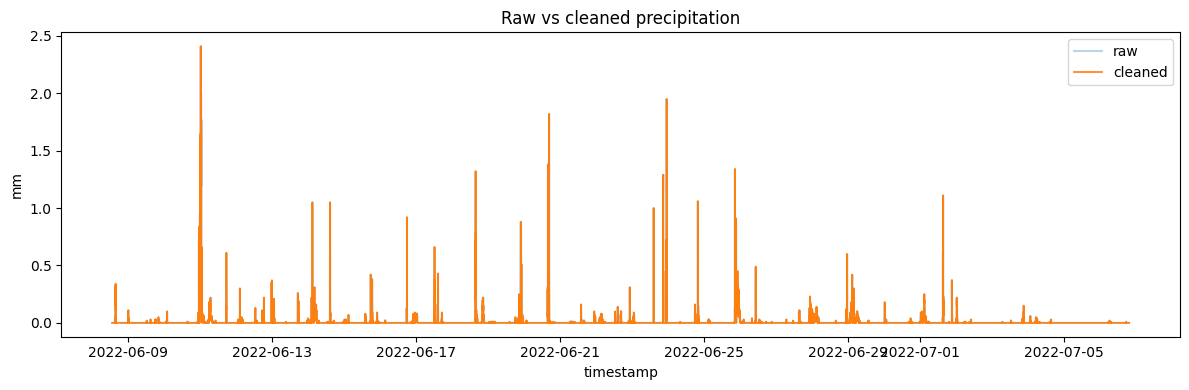

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(sample_with_gaps['ts'], sample_with_gaps['value_mm'], alpha=0.3, label='raw')
plt.plot(cleaned_sample['ts'], cleaned_sample['value_mm'], linewidth=1.2, label='cleaned')
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('mm')
plt.title('Raw vs cleaned precipitation')
plt.tight_layout()


## 3. Optional: pull from database

In [ ]:
load_dotenv(BASE_DIR / '.env')
DATABASE_URL = os.getenv('DATABASE_URL')


In [ ]:
if DATABASE_URL:
    engine = sa.create_engine(DATABASE_URL, pool_pre_ping=True, future=True)
    cutoff = datetime.now(timezone.utc) - timedelta(hours=72)
    raw_db = fetch_raw_measurements(engine, cutoff)
    display(raw_db.head(100))
    if not raw_db.empty:
        cleaned_db = clean_measurements(raw_db, CleanerConfig())
        display(cleaned_db.head(100))
else:
    print('DATABASE_URL not set; skipping DB fetch.')


,sensor_id,ts,value_mm,quality,variable,source
0,pluvio_1,2025-09-28 06:16:20+00:00,0.0,NaN,precipitacion,current
1,pluvio_1,2025-09-28 08:08:12+00:00,0.0,NaN,precipitacion,current
2,pluvio_1,2025-09-28 20:38:40+00:00,0.0,NaN,precipitacion,current
3,pluvio_10,2025-09-28 06:16:20+00:00,NaN,NaN,precipitacion,current
4,pluvio_10,2025-09-28 08:08:12+00:00,NaN,NaN,precipitacion,current
...,...,...,...,...,...,...
95,pluvio_201,2025-09-28 20:38:40+00:00,0.0,NaN,precipitacion,current
96,pluvio_202,2025-09-28 06:16:20+00:00,0.0,NaN,precipitacion,current
97,pluvio_202,2025-09-28 08:08:12+00:00,0.0,NaN,precipitacion,current
98,pluvio_202,2025-09-28 20:38:40+00:00,0.0,NaN,precipitacion,current


,sensor_id,ts,value_mm,qc_flags,imputation_method,version
0,pluvio_1,2025-09-28 06:16:20+00:00,0.0,0,None,1
1,pluvio_1,2025-09-28 08:08:12+00:00,0.0,0,None,1
2,pluvio_1,2025-09-28 20:38:40+00:00,0.0,0,None,1
3,pluvio_1019,2025-09-28 06:16:20+00:00,0.0,0,None,1
4,pluvio_1019,2025-09-28 08:08:12+00:00,0.0,0,None,1
...,...,...,...,...,...,...
95,pluvio_23,2025-09-28 20:38:40+00:00,0.0,0,None,1
96,pluvio_230,2025-09-28 06:16:20+00:00,0.0,0,None,1
97,pluvio_230,2025-09-28 08:08:12+00:00,0.0,0,None,1
98,pluvio_230,2025-09-28 20:38:40+00:00,0.0,0,None,1


In [ ]:
if DATABASE_URL:
    engine = sa.create_engine(DATABASE_URL, pool_pre_ping=True, future=True)
    cutoff = datetime.now(timezone.utc) - timedelta(hours=72)
    raw_db = fetch_raw_measurements(engine, cutoff)
    
    # Filter to show only non-zero measurements
    non_zero_raw = raw_db[raw_db['value_mm'] != 0.0]
    display(non_zero_raw.head(100))
    
    if not raw_db.empty:
        cleaned_db = clean_measurements(raw_db, CleanerConfig())
        
        # Filter cleaned data to show only non-zero measurements
        non_zero_cleaned = cleaned_db[cleaned_db['value_mm'] != 0.0]
        display(non_zero_cleaned.head(100))
else:
    print('DATABASE_URL not set; skipping DB fetch.')


,sensor_id,ts,value_mm,quality,variable,source
3,pluvio_10,2025-09-28 06:16:20+00:00,NaN,NaN,precipitacion,current
4,pluvio_10,2025-09-28 08:08:12+00:00,NaN,NaN,precipitacion,current
5,pluvio_10,2025-09-28 20:38:40+00:00,NaN,NaN,precipitacion,current
15,pluvio_12,2025-09-28 06:16:20+00:00,NaN,NaN,precipitacion,current
16,pluvio_12,2025-09-28 08:08:12+00:00,NaN,NaN,precipitacion,current
...,...,...,...,...,...,...
527,pluvio_512,2025-09-28 20:38:40+00:00,NaN,NaN,precipitacion,current
531,pluvio_517,2025-09-28 06:16:20+00:00,NaN,NaN,precipitacion,current
532,pluvio_517,2025-09-28 08:08:12+00:00,NaN,NaN,precipitacion,current
533,pluvio_517,2025-09-28 20:38:40+00:00,NaN,NaN,precipitacion,current


,sensor_id,ts,value_mm,qc_flags,imputation_method,version
306,pluvio_427,2025-09-28 06:16:20+00:00,0.01,0,None,1
307,pluvio_427,2025-09-28 08:08:12+00:00,0.01,0,None,1
308,pluvio_427,2025-09-28 20:38:40+00:00,0.01,0,None,1
471,pluvio_615,2025-09-28 06:16:20+00:00,0.50,0,None,1
472,pluvio_615,2025-09-28 08:08:12+00:00,0.50,0,None,1
473,pluvio_615,2025-09-28 20:38:40+00:00,0.50,0,None,1
504,pluvio_713,2025-09-28 06:16:20+00:00,0.02,0,None,1
505,pluvio_713,2025-09-28 08:08:12+00:00,0.02,0,None,1
506,pluvio_713,2025-09-28 20:38:40+00:00,0.02,0,None,1
